In [1]:
from network import Network
from utils import unzip
from tqdm import trange
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.animation as animation
from matplotlib import rc

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

Test ID -> coords -> ID: OK


In [2]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def render(ims):

    fig = plt.figure()
    frames = [[plt.imshow(im, animated=True)] for im in ims]
    plt.close()
    
    ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                    repeat_delay=1000)

    return ani

In [3]:
comm_side = 6
comms_per_side = 4
threshold = int((comm_side * comm_side - 1) / 2)
wires = comm_side * comm_side - 1
net = Network(
    comm_side=comm_side,
    comms_per_side=comms_per_side,
    locality=0.1,
    threshold=threshold,
)
print(f"wires {wires}, threshold {threshold}")

wires 35, threshold 17


In [4]:
net.initialize(wires)

In [5]:
metrics = []

In [6]:
t = trange(10)
spikes = []
for it in t:
    net.spark()
    t.set_description(f"ITERATION {it}")
    for ep in range(10):
        net.check()
        net.gossip()
        net.update()
        # net.inspect()
        net.optimize()
        if net.dead():
            break
    episode = np.array(net.spiking_history[-ep:])
    avg_spikes = episode.sum() / episode.size
    metrics.append((ep, avg_spikes, net.mu()))

ITERATION 9: 100%|██████████| 10/10 [00:02<00:00,  4.09it/s]


In [7]:
eps, avg_spikes, mus = unzip(metrics)

In [8]:
spikes = [state.sum()/state.size for state in net.spiking_history]

In [9]:
def ep_range(eps):
    # add one to make the episodes not overlap
    eps_ends = (np.array(eps)+1).cumsum()
    # make time chinks
    time = [list(range(start,stop)) for start, stop in zip(eps_ends, eps_ends[1:])]
    # yield triplets
    for ((start, stop),t) in zip(zip(eps_ends, eps_ends[1:]),time):
        yield (t, start, stop)

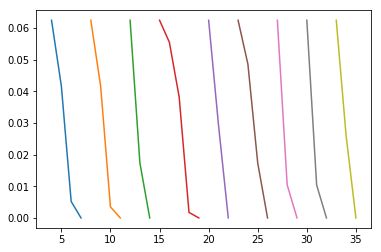

In [10]:
for t,start,stop in ep_range(eps):
    plt.plot(t, spikes[start:stop])

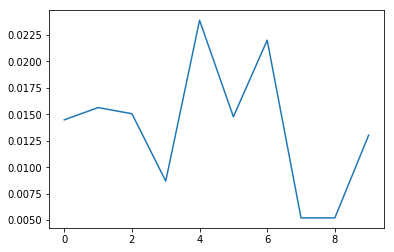

In [11]:
plt.plot(avg_spikes)

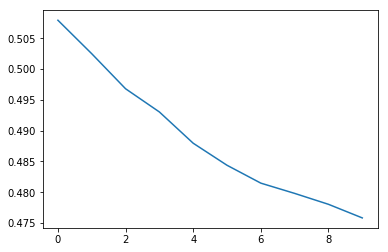

In [12]:
plt.plot(mus)

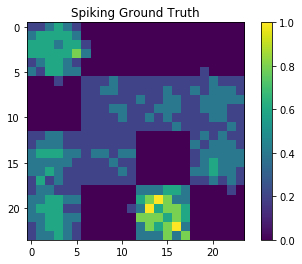

In [13]:
# To check how well gossipping is doing I'll compute the activity ground-truth
gt = np.array(net.spiking_history).sum(axis=0)
gt /= gt.max() # we are interested in proportions of activity, not actual value
plt.imshow(gt)
plt.title("Spiking Ground Truth")
plt.colorbar()

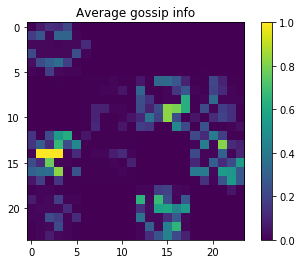

In [14]:
# gather the info shared by all agents by gossiping
collective_info = np.array([node.info for node in net.nodes])
collective_info = collective_info.sum(axis=0)
        
collective_info /= collective_info.max()
plt.imshow(collective_info)
plt.title("Average gossip info")
plt.colorbar()

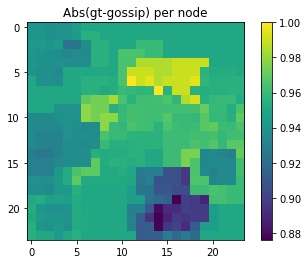

In [15]:
# compare the two by the abs diff of each node against the gt
# gossip status -> (gt-gossip)
gossip = np.zeros((net.N,net.N))
for node in net.nodes:
    gossip_matrix = np.copy(node.info)
    # normalize gossip matrix if there is any gossip
    gossip_level = node.info.max()
    if(gossip_level > 0):
        gossip_matrix /= gossip_level
    perf = np.abs(gt-gossip_matrix).sum()
    gossip[node.coords] = perf

gossip /= gossip.max()

plt.imshow(gossip)
plt.colorbar()
plt.title("Abs(gt-gossip) per node")
plt.show()

In [17]:
def render_diffusion():
    comm_side = 6
    comms_per_side = 4
    threshold = int((comm_side * comm_side - 1) / 2)
    wires = comm_side * comm_side - 1
    net = Network(
        comm_side=comm_side,
        comms_per_side=comms_per_side,
        locality=0.1,
        threshold=threshold,
    )
    print(f"wires {wires}, threshold {threshold}")
    net.initialize(wires)
    frames = []
    t = trange(50)
    for it in t:
        net.spark()
        t.set_description(f"ITERATION {it}")
        for ep in range(15):
            net.check()
            net.gossip()
            net.update()
            # net.inspect()
            net.optimize()
            
            # compare the two by the abs diff of each node against the gt
            # gossip status -> (gt-gossip)
            gossip = np.zeros((net.N,net.N))
            # To check how well gossipping is doing I'll compute the activity ground-truth
            gt = np.array(net.spiking_history).sum(axis=0)
            gt /= gt.max() # we are interested in proportions of activity, not actual value
            for node in net.nodes:
                gossip_matrix = np.copy(node.info)
                # normalize gossip matrix if there is any gossip
                gossip_level = node.info.max()
                if(gossip_level > 0):
                    gossip_matrix /= gossip_level
                perf = np.abs(gt-gossip_matrix).sum()
                gossip[node.coords] = perf

            gossip /= gossip.max()

            
            frames.append(gossip)
            
            if net.dead():
                break
    frames = np.array(frames)
    frames /= frames.max()
    return render(frames)

diff_render = render_diffusion()



  0%|          | 0/50 [00:00<?, ?it/s]

ITERATION 0:   0%|          | 0/50 [00:00<?, ?it/s]

wires 35, threshold 17




ITERATION 0:   2%|▏         | 1/50 [00:00<00:10,  4.80it/s]

ITERATION 1:   2%|▏         | 1/50 [00:00<00:10,  4.80it/s]

ITERATION 1:   4%|▍         | 2/50 [00:00<00:10,  4.68it/s]

ITERATION 2:   4%|▍         | 2/50 [00:00<00:10,  4.68it/s]

ITERATION 2:   6%|▌         | 3/50 [00:00<00:10,  4.37it/s]

ITERATION 3:   6%|▌         | 3/50 [00:00<00:10,  4.37it/s]

ITERATION 3:   8%|▊         | 4/50 [00:00<00:10,  4.55it/s]

ITERATION 4:   8%|▊         | 4/50 [00:00<00:10,  4.55it/s]

ITERATION 4:  10%|█         | 5/50 [00:01<00:10,  4.21it/s]

ITERATION 5:  10%|█         | 5/50 [00:01<00:10,  4.21it/s]

ITERATION 5:  12%|█▏        | 6/50 [00:01<00:10,  4.04it/s]

ITERATION 6:  12%|█▏        | 6/50 [00:01<00:10,  4.04it/s]

ITERATION 6:  14%|█▍        | 7/50 [00:01<00:10,  4.17it/s]

ITERATION 7:  14%|█▍        | 7/50 [00:01<00:10,  4.17it/s]

ITERATION 7:  16%|█▌        | 8/50 [00:01<00:10,  3.89it/s]

ITERATION 8:  16%|█▌        | 8/50 [00:01<00:10,  3.89it/s]

ITERATION 8:  18%|█▊  

In [18]:
diff_render

In [19]:
diff_render.save("gossip_diffusion.mp4")

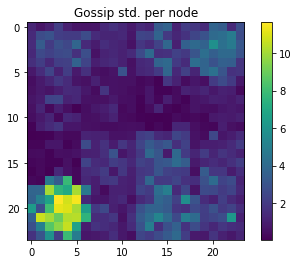

In [34]:
# check agents agreement using the std of their gossip "matrices"
# compare the previous gt with the info shared by all agents by gossiping
collective_info = np.array([node.info for node in net.nodes])
        
plt.imshow(collective_info.std(axis=0))
plt.title("Gossip std. per node")
plt.colorbar()

Text(0.5, 1.0, 'Communities')

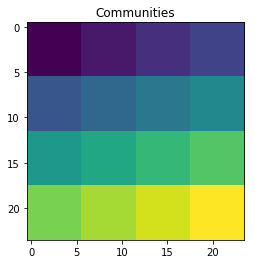

In [35]:
comms = np.zeros((net.N,net.N))
for node in net.nodes:
    comms[node.coords] = node.community
plt.imshow(comms)
plt.title("Communities")

In [27]:
spike_ani = render(net.spiking_history)

In [28]:
spike_ani

In [31]:
spike_ani.save("spikes.mp4")

In [29]:
activ_ani = render(net.activity_history)

In [30]:
activ_ani

In [32]:
activ_ani.save("activity.mp4")